# inspect single reconstructions

In [1]:
import warnings; warnings.filterwarnings("ignore")

from vae import Encoder, Decoder
from ensemble import Ensemble
from utils import DEVICE

# checkpoint_folder = './rgbd_checkpoints_vanilla'
checkpoint_folder = './rgbd_checkpoints_contrastive'

resolution = (128, 128)
    
model_args = {'appearance_latent_dim': 128,
              'structure_latent_dim': 128,
              'hidden_dims': [32, 64, 128, 256, 512]}

# make ensemble
models = {'RGB_appearance': Encoder(input_shape=[3, *resolution], latent_dim=model_args['appearance_latent_dim'], hidden_dims=model_args['hidden_dims']), 
          'RGB_structure': Encoder(input_shape=[3, *resolution], latent_dim=model_args['structure_latent_dim'], hidden_dims=model_args['hidden_dims']), 
          'DEPTH_structure': Encoder(input_shape=[1, *resolution], latent_dim=model_args['structure_latent_dim'], hidden_dims=model_args['hidden_dims'])}
models['RGB_decoder'] = Decoder(input_shape=[3, *resolution], 
                                latent_dim=model_args['appearance_latent_dim'] + model_args['structure_latent_dim'], 
                                encoder_conv_out_shape=models['RGB_appearance'].conv_out_shape, 
                                hidden_dims=model_args['hidden_dims'])
model = Ensemble(models).float().to(DEVICE)
model.load_checkpoint(checkpoint_folder)

ENCODER INFO: after convolutions but before flattening, the shape is 512x4x4
ENCODER INFO: after convolutions but before flattening, the shape is 512x4x4
ENCODER INFO: after convolutions but before flattening, the shape is 512x4x4
DECODER INFO: before resizing, generations have resolution 128x128!
MODEL INFO: no loss weights were provided. i cant calculate the loss but i will do the best i can :)
MODEL INFO: loading checkpoint from ./rgbd_checkpoints_contrastive


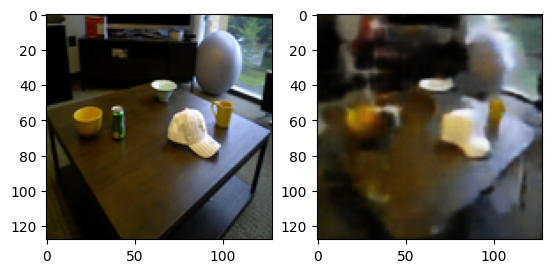

In [4]:
import matplotlib.pyplot as plt
import torch

from datasets import RGBDDataset

if 'dataset' not in locals():  # avoid loading dataset all the time
    dataset = RGBDDataset(resolution)
dataloader = dataset.get_dataloader('test', 1)

with torch.no_grad():
    for x, in dataloader:
        out = model.infer(x)
        emb = torch.cat((out.RGB_appearance, out.RGB_structure), dim=-1)
        rec = models['RGB_decoder'](emb)
        
        x = (x.squeeze()[:3].permute(1, 2, 0).cpu().numpy() + 1) / 2
        rec = (rec.squeeze().permute(1, 2, 0).cpu().numpy() + 1) / 2
        
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(x)
        ax[1].imshow(rec)
                                                                                     
        break

# encode entire dataset

In [5]:
from collections import defaultdict
import tqdm
import numpy as np

embeddings = defaultdict(list)
labels = []

if 'dataset' not in locals():  # avoid loading dataset all the time
    dataset = RGBDDataset(resolution)
dataloader = dataset.get_dataloader('all', 1, include_scene_labels=True, shuffle=False)

for x, label in tqdm.tqdm(dataloader):
    emb = model.infer(x)
    embeddings['RGB_appearance'].append(emb.RGB_appearance)
    embeddings['RGB_structure'].append(emb.RGB_structure)
    embeddings['DEPTH_structure'].append(emb.DEPTH_structure)
    labels.append(int(label.item()))

for k in embeddings.keys():
    embeddings[k] = torch.cat(embeddings[k]).numpy()

100%|█████████████████████████████████████| 11427/11427 [02:09<00:00, 88.41it/s]


# run TSNE plots

In [6]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

method = TSNE
# method = PCA

# run TSNE or PCA
reduced_embeddings = {}
for k in tqdm.tqdm(embeddings.keys()):
    reduced_embeddings[k] = method(n_components=2).fit_transform(embeddings[k])

100%|█████████████████████████████████████████████| 3/3 [01:33<00:00, 31.32s/it]


<Axes: >

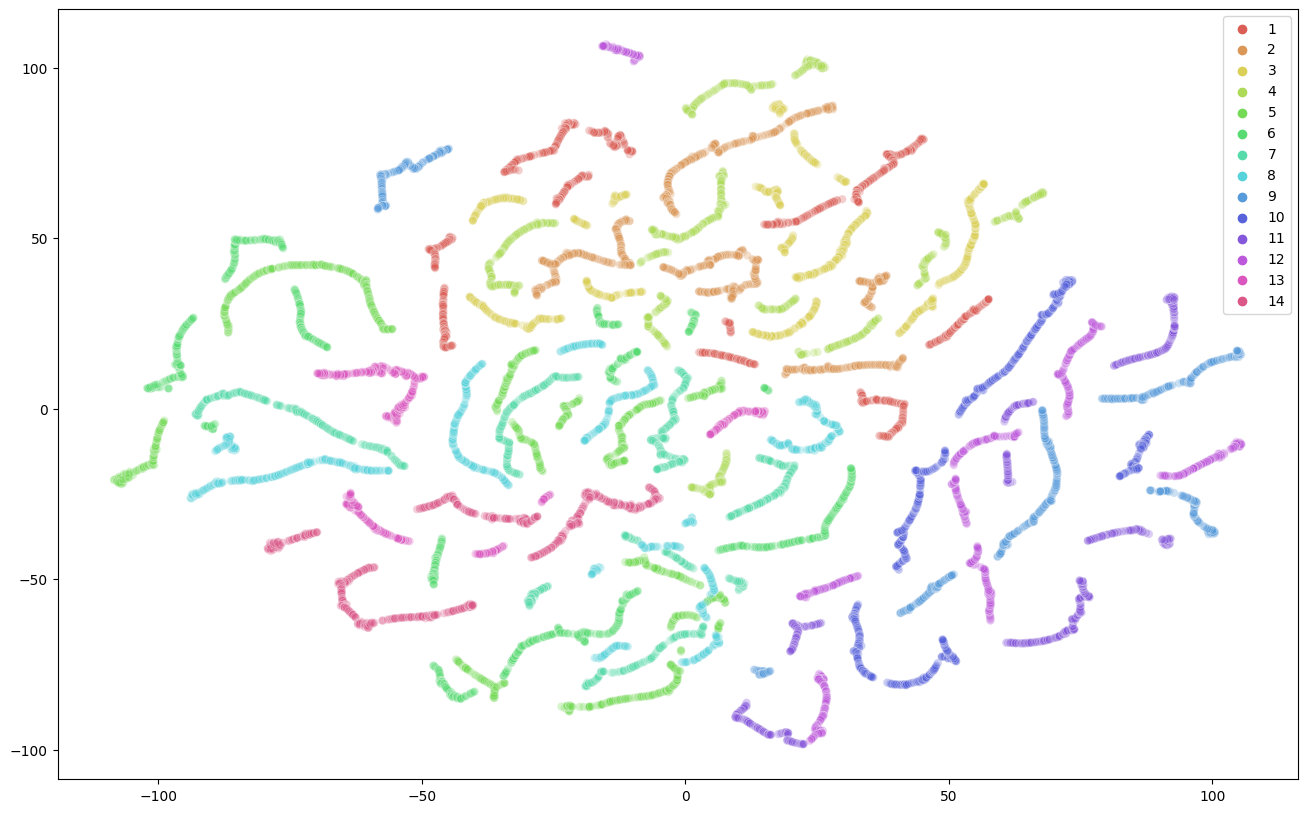

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

key = 'RGB_structure'; assert key in ['RGB_appearance', 'RGB_structure', 'DEPTH_structure']

# plot TSNE/PCA, separated by scene
X = reduced_embeddings[key]
hue = labels
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X[:, 0], y=X[:, 1],
    hue=hue,
    palette=sns.color_palette("hls", 14),
    legend="full",
    alpha=0.3
)

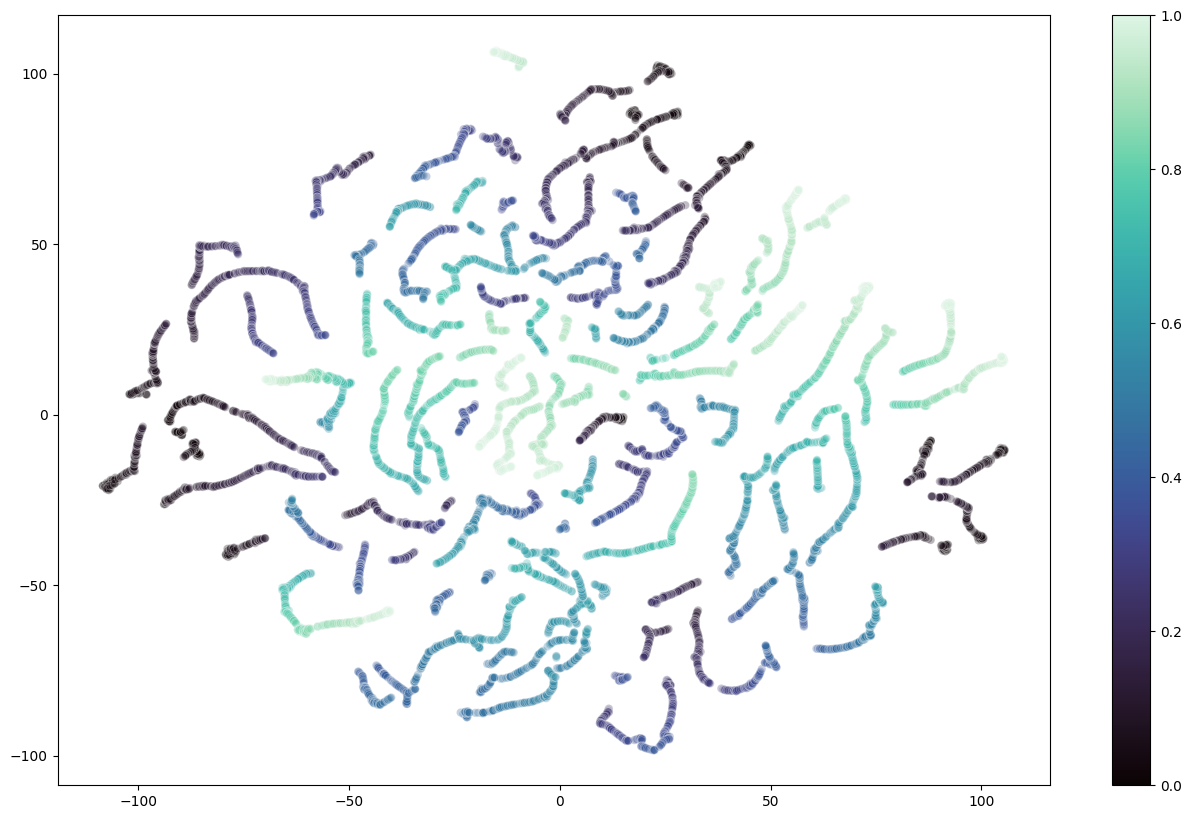

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

key = 'RGB_structure'; assert key in ['RGB_appearance', 'RGB_structure', 'DEPTH_structure']

# plot TSNE/PCA, separated by view direction for each scene
plt.figure(figsize=(16,10))


plot = plt.scatter([0, 1], [0, 1], c=[0, 1], cmap='mako'); plt.clf(); plt.colorbar(plot)  # finesse colorbar from plt

for scene in range(1, 15):
    idxs = [i for i in range(len(labels)) if labels[i] == scene]
#     print('{} datapoints in this scene!'.format(len(idxs)))
    X = reduced_embeddings[key][idxs]
    hue = np.linspace(0, 1, len(idxs))
    ax = sns.scatterplot(
                x=X[:, 0], y=X[:, 1],
                hue=hue,
                palette=sns.color_palette("mako", as_cmap=True),
                legend='auto',
                alpha=0.3
    )
    ax.legend_.remove()